# PROPHET

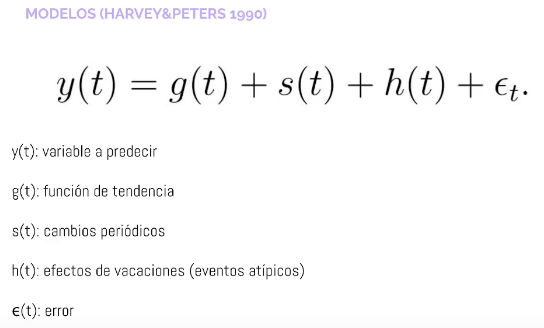

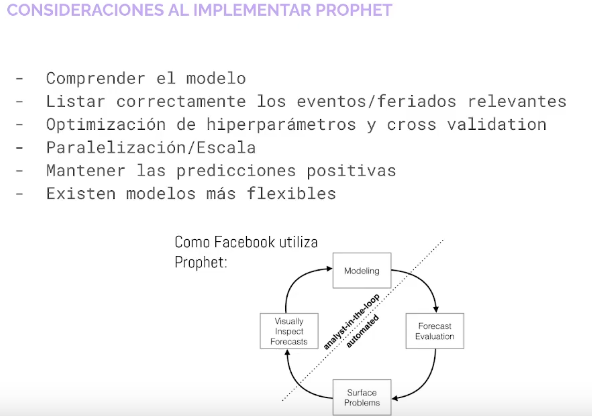

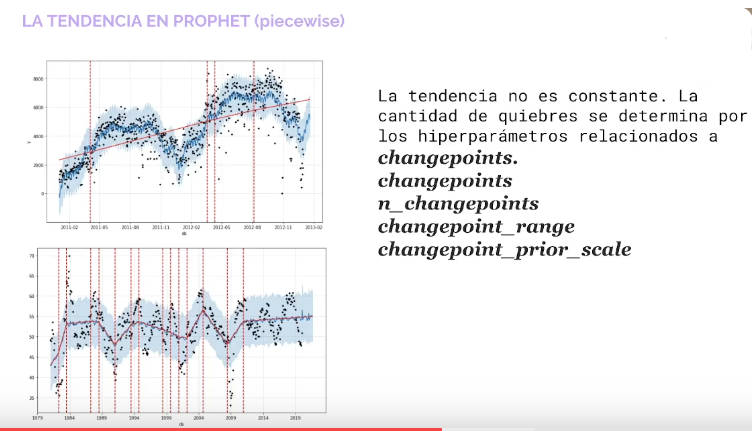

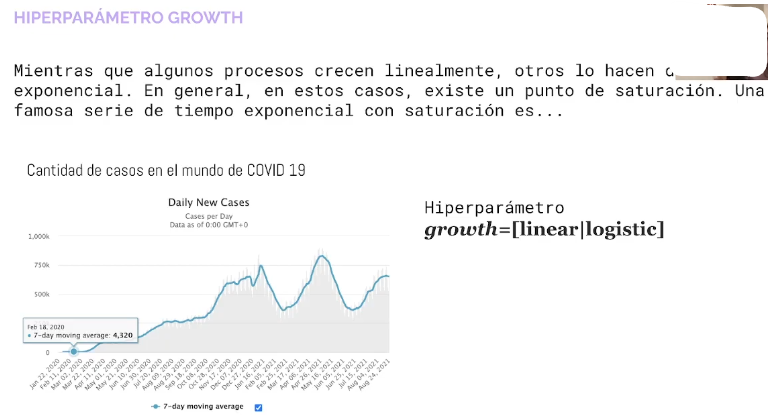

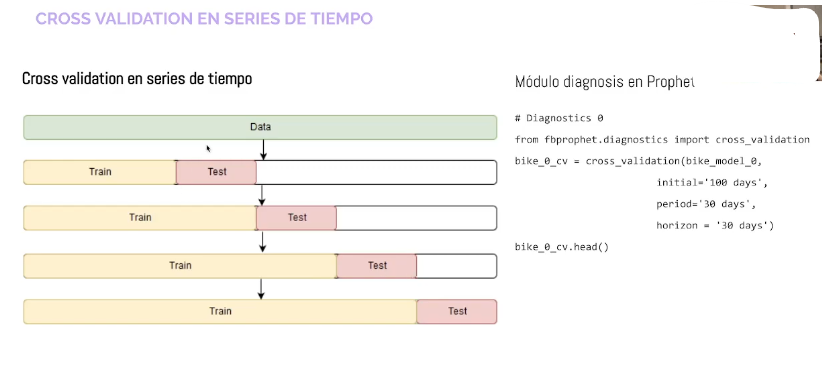

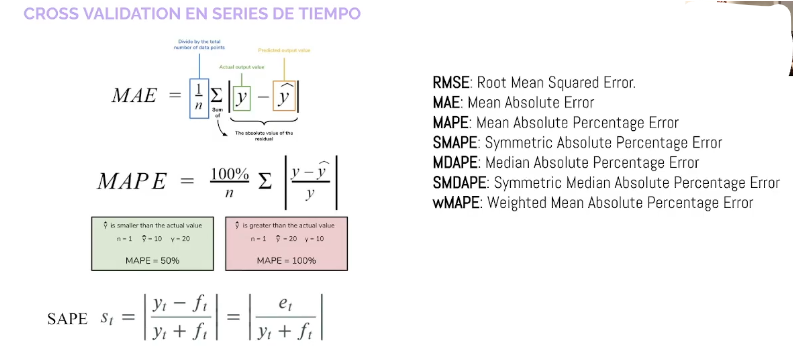

In [3]:
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
from matplotlib import pyplot as plt
from plotly import offline as py
plt.rcParams["figure.figsize"] = (20,5)

c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv('../0.data/time_series/monthly_temp.csv')
data.ds = pd.to_datetime(data.ds)
train = data.copy()
train.head(10)

,ds,y
0,1895-01-01,26.69
1,1895-02-01,26.60
2,1895-03-01,39.97
3,1895-04-01,52.90
4,1895-05-01,59.94
5,1895-06-01,67.80
6,1895-07-01,71.24
7,1895-08-01,71.62
8,1895-09-01,65.57
9,1895-10-01,50.85


In [5]:
# generar un dataset futuro para hacer la prediccion, desde
# 2021 a 2090 -> lo que queremos que prediga el modelo
futuro = pd.DataFrame({'ds': pd.to_datetime(
    [x for x in range(2021, 2090)], format='%Y'), 'y': np.nan})

11:50:24 - cmdstanpy - INFO - Chain [1] start processing
11:50:25 - cmdstanpy - INFO - Chain [1] done processing


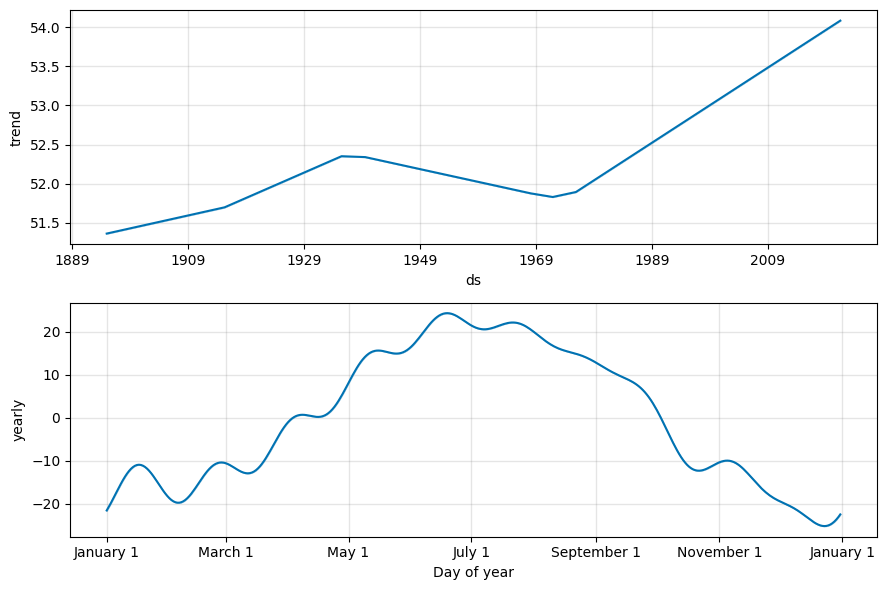

In [6]:
# instanciamos el modelo
m = Prophet()

# entrenamos el modelo en TRAIN
m.fit(train)

# predecimos 
forecast = m.predict(futuro)

# para graficar, hacemos predict tambien en train
forecast_train = m.predict(train)

# unimos los dos DFs para visualizar las dos partes, train-prediccion
forecast_final = pd.concat([forecast_train, forecast])

# #plot componentes del forecast
m.plot_components(forecast_train);

vemos como prophet captura la estacionalidad anual y la tendencia creciente.

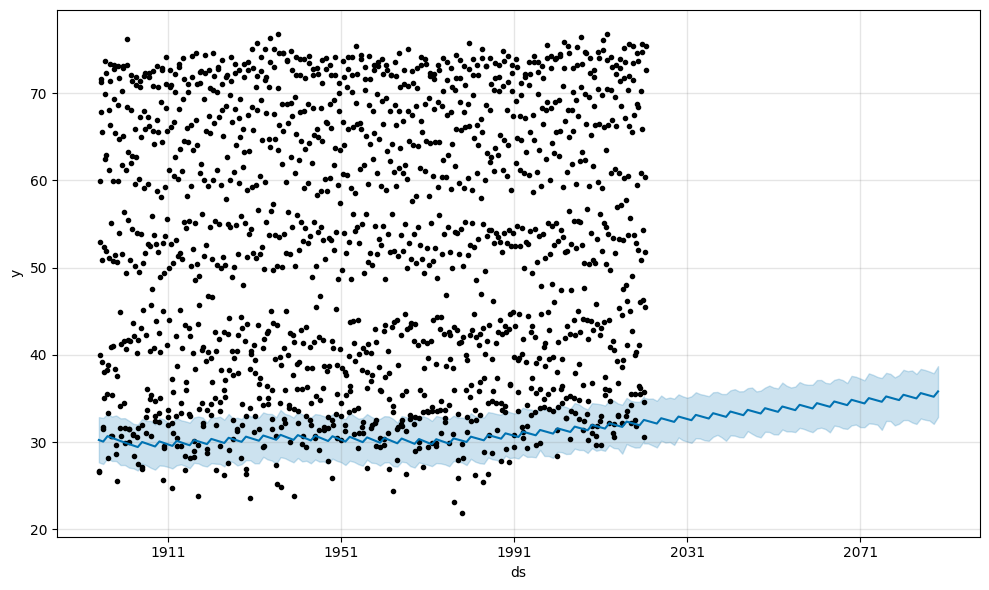

In [7]:
m.plot(forecast_final[forecast_final['ds'].dt.month==1])
plt.show()

In [8]:
# podemos pasar una grilla de hiperparámetros y probar con rolloing cross validation
# el set que minimiza el error. En este caso el MAE. Luego repetimos la prediccion
# con el mejor set de hiperparámetros.

# nombrar hiperparametros mas importantes, changepoint_prior_scale y changepoint range. como funcionan.
# prophet tambine puede recibir regresores de una matriz de datos.
# fechas de feriados para argentina y otros paises, etc.


param_grid = {
    'changepoint_prior_scale': [0.001, 0.05],  # default 0.05
    'seasonality_prior_scale': [10.0, 0.01, 1.0],  # default 10
    'seasonality_mode': ["additive", "multiplicative"]}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here
counter = 1
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    print(counter)
    counter = counter + 1

    m.fit(train)  # Fit model with given params

    initial_forecast_date = '1980-01-01'
    initial = str(
        abs(data[data.ds > initial_forecast_date].shape[0] - data.shape[0])) + ' days'

# tendremos 100 años de entrenamiento fijos
# luego haremos predicciones cada 10 años de 5 años de ventana de prediccion
# sucesivamente hasta que los datos se agoten.

    df_cv = cross_validation(
        m, initial='36500 days', period='3650 days', horizon='1825 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=5)
    # rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])  # USAMOS EL MAE


tuning_results = pd.DataFrame(all_params)

tuning_results['mae'] = maes
print(tuning_results)
best_params = all_params[np.argmin(maes)]
print(best_params)

11:55:19 - cmdstanpy - INFO - Chain [1] start processing


1


11:55:20 - cmdstanpy - INFO - Chain [1] done processing
11:55:23 - cmdstanpy - INFO - Chain [1] start processing


2


11:55:24 - cmdstanpy - INFO - Chain [1] done processing
11:55:26 - cmdstanpy - INFO - Chain [1] start processing


3


11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:29 - cmdstanpy - INFO - Chain [1] start processing


4


11:55:29 - cmdstanpy - INFO - Chain [1] done processing
11:55:32 - cmdstanpy - INFO - Chain [1] start processing


5


11:55:32 - cmdstanpy - INFO - Chain [1] done processing
11:55:35 - cmdstanpy - INFO - Chain [1] start processing


6


11:55:35 - cmdstanpy - INFO - Chain [1] done processing
11:55:38 - cmdstanpy - INFO - Chain [1] start processing


7


11:55:38 - cmdstanpy - INFO - Chain [1] done processing
11:55:40 - cmdstanpy - INFO - Chain [1] start processing


8


11:55:41 - cmdstanpy - INFO - Chain [1] done processing
11:55:43 - cmdstanpy - INFO - Chain [1] start processing


9


11:55:44 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing


10


11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:49 - cmdstanpy - INFO - Chain [1] start processing


11


11:55:49 - cmdstanpy - INFO - Chain [1] done processing
11:55:52 - cmdstanpy - INFO - Chain [1] start processing


12


11:55:52 - cmdstanpy - INFO - Chain [1] done processing


    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                    10.00         additive   
1                     0.001                    10.00   multiplicative   
2                     0.001                     0.01         additive   
3                     0.001                     0.01   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.050                    10.00         additive   
7                     0.050                    10.00   multiplicative   
8                     0.050                     0.01         additive   
9                     0.050                     0.01   multiplicative   
10                    0.050                     1.00         additive   
11                    0.050                     1.00   multiplicative   

         mae  
0   1.595078  
1   1.658472  
2   1

In [9]:


# el mejor set de hiperparámetros
best_params



{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative'}

In [ ]:
# DATASET: https://www.ncei.noaa.gov/products/climate-data-records